# BoomBikes Bike Sharing Assignment

The given problem statement is to analyze the given dataset and to find significant factor that contribute to the incease or decrease of bike sales in a particular year, and to create a linear regression model using those factors that can predict the bike sales given some data, e.g. weather situation, day of week etc.

In [299]:
#Importing necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from sklearn.metrics import r2_score

# Reading and Understanding the data

In [300]:
# Reading the day csv file into dataframe

df_bike = pd.read_csv('day.csv')

df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [301]:
# Inspecting the dataset

print(df_bike.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


Here we can directly eliminate 3 columns:

- instant, as it seems to be an index column
- casual and registered counts, as they add up  to the target variable, and we asked only to predict total count of bikes sold that year

In [302]:
df_bike.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df_bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [303]:
# Checking the shape of the dataset to get count of null values

df_bike.shape

(730, 13)

As we can see form the two outputs above, all 730 rows are non null across all columns - so no null values imputations o handling is required

## Data Visualization

We can see the relationship of all the categorical and numerical variables with respect to the target variable count using pair plots and box plots

This can hep us get a fair idea which variables show strong linear relationship with count at the start itself

<Figure size 2160x1080 with 0 Axes>

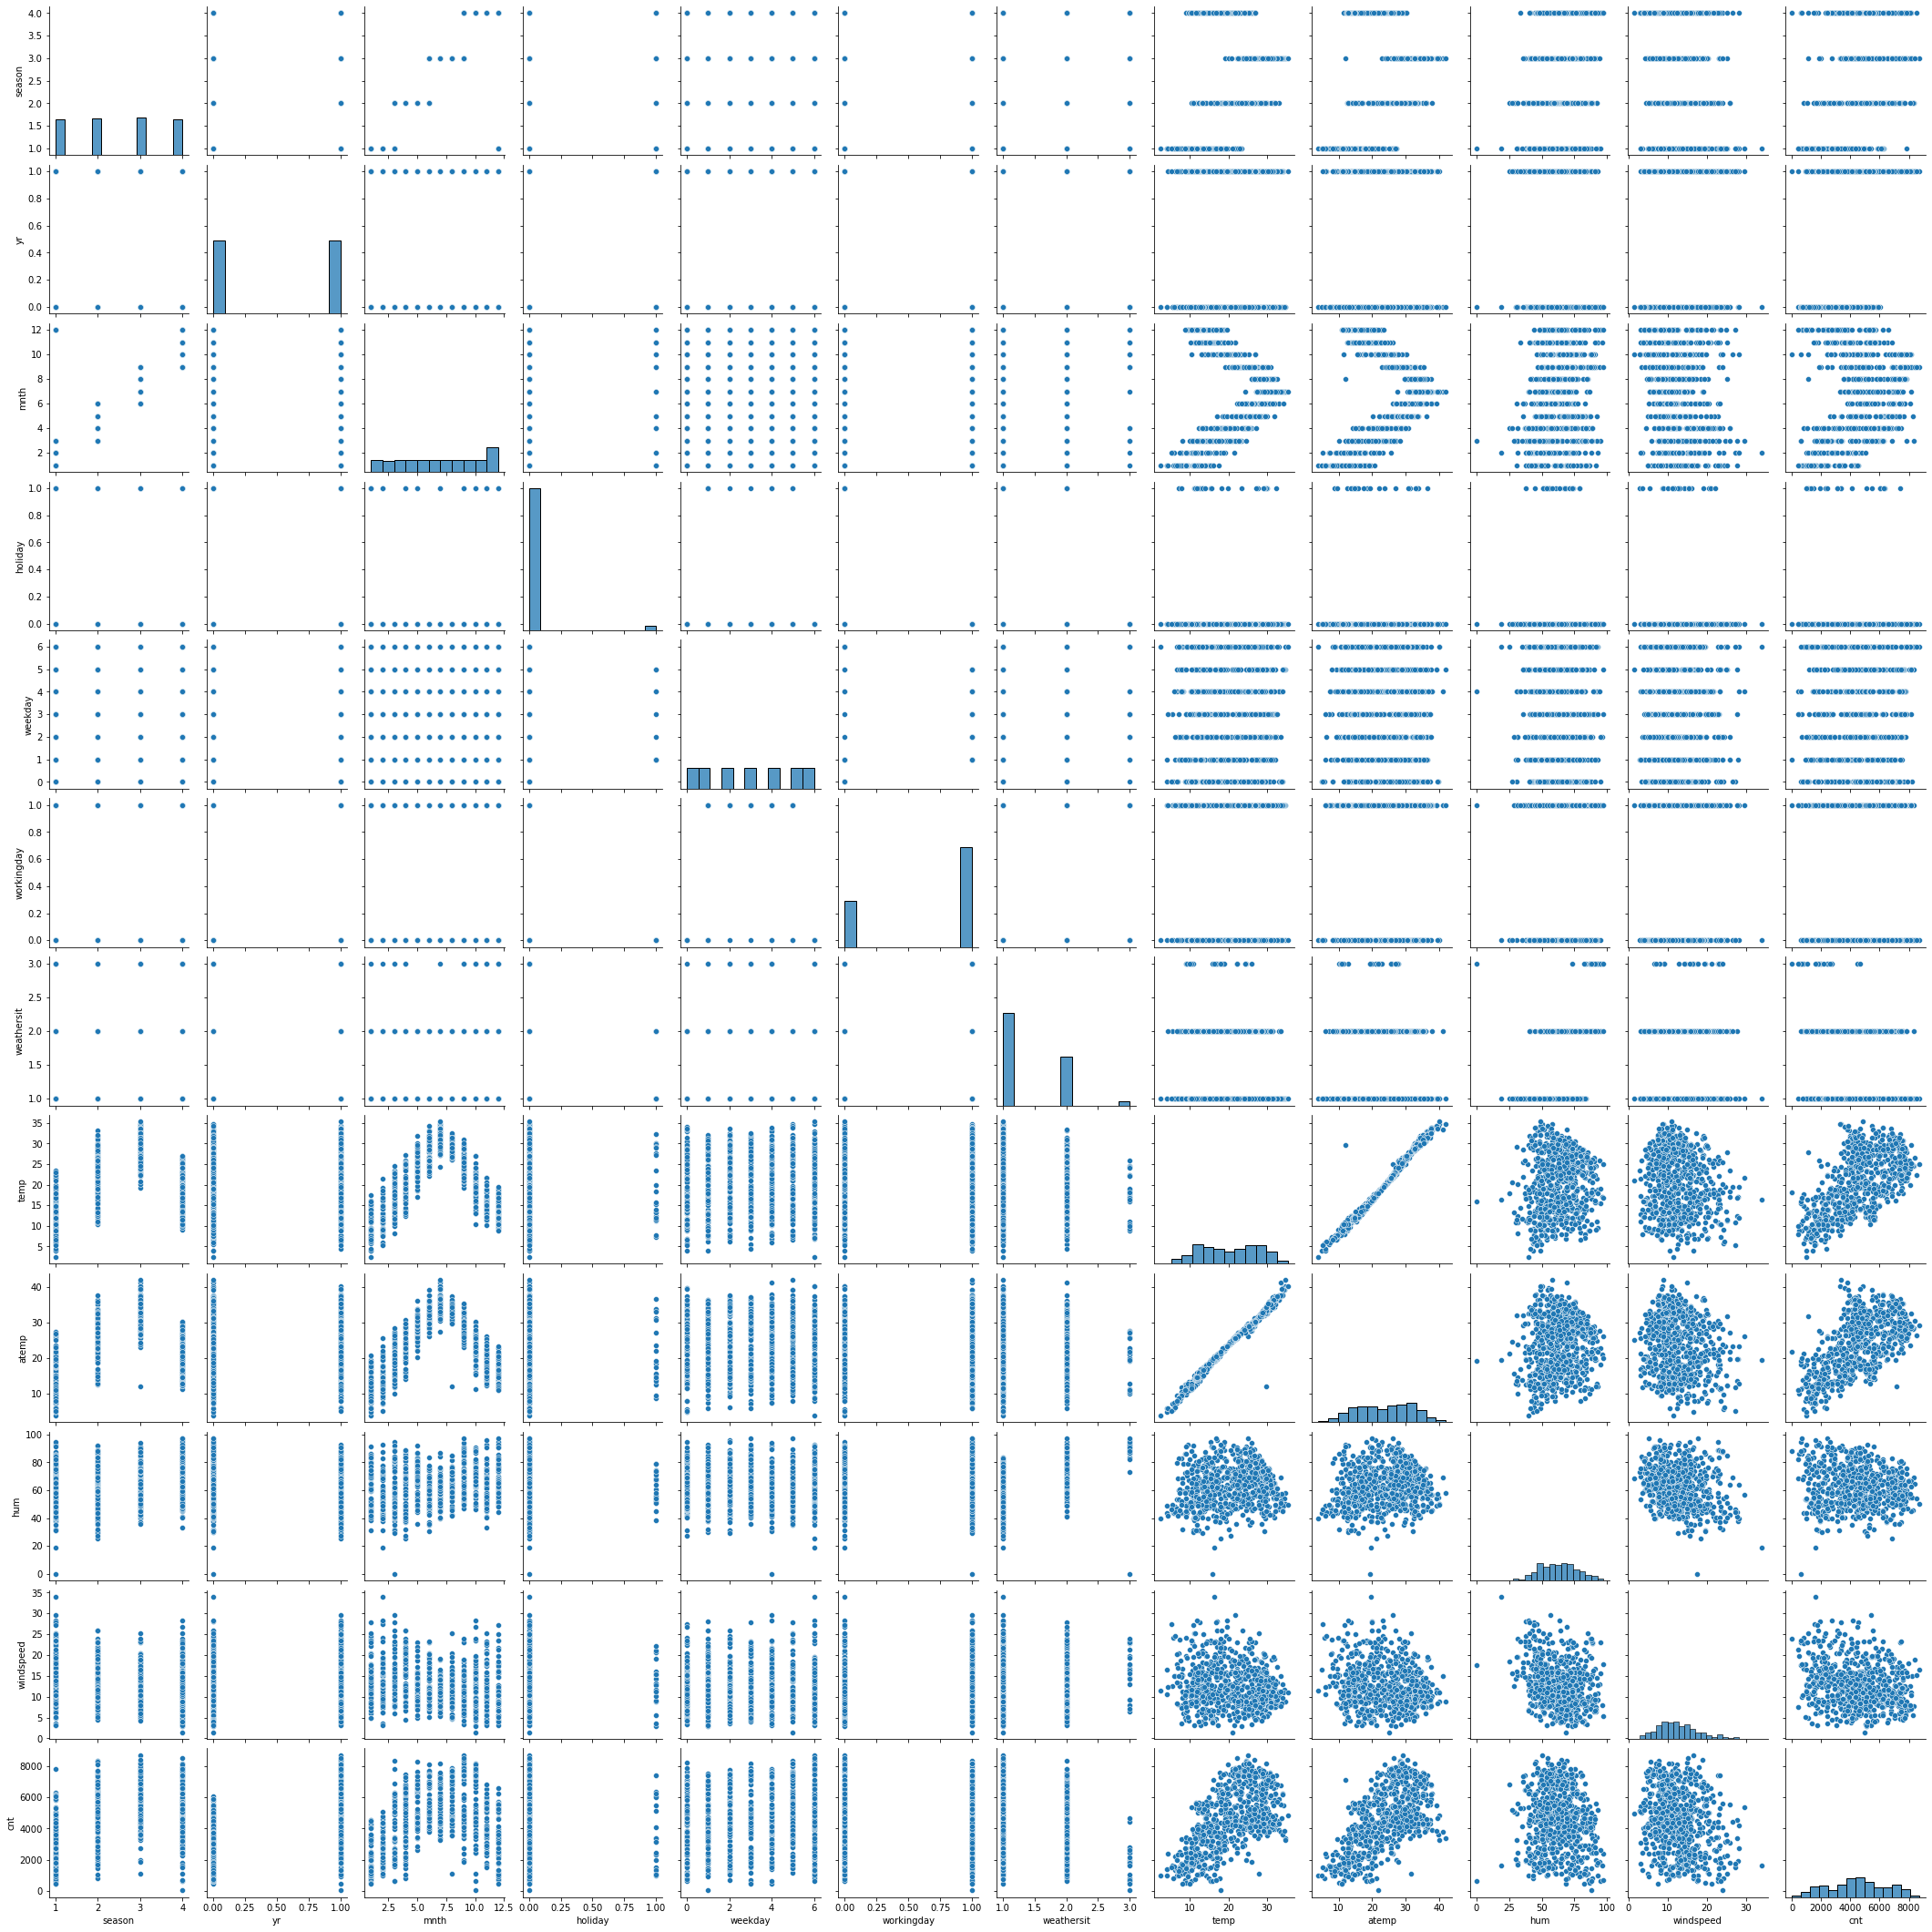

In [304]:
#Using seaborn for pari plots

plt.figure(figsize=(30,15))
sns.pairplot(df_bike)
plt.show()

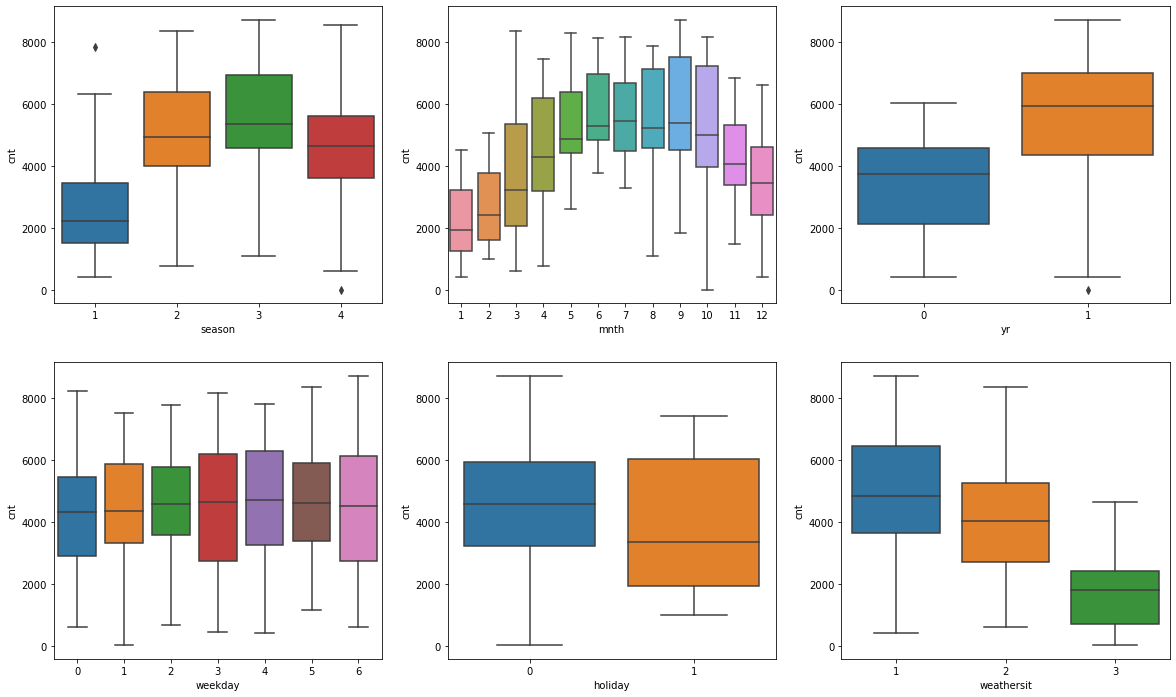

In [305]:
#Using box plots to determine relationships between categroical variables and the target variable

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_bike)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike)
plt.subplot(2,3,3)
sns.boxplot(x = 'yr', y = 'cnt', data = df_bike)
plt.subplot(2,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(2,3,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)
plt.subplot(2,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike)
plt.show()

## Data Preparation

- In order to fit a straight line with a linear regression model, we would need numerical values for all the predictor variables.

- Hence, we will convert all the categorical variables into dummy or encoded numerical variables

In [306]:
#As mentioned in the problem statement, the order of the season variable, which is categorical in nature, does not make any sens. So replaccing them with their original string values

df_bike['season'] = df_bike['season'].replace(1, 'spring')
df_bike['season'] = df_bike['season'].replace(2, 'summer')
df_bike['season'] = df_bike['season'].replace(3, 'fall')
df_bike['season'] = df_bike['season'].replace(4, 'winter')

df_bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [307]:
# Similar treatment for the weathersit variable

df_bike['weathersit'] = df_bike['weathersit'].replace(1, 'clear')
df_bike['weathersit'] = df_bike['weathersit'].replace(2, 'mist')
df_bike['weathersit'] = df_bike['weathersit'].replace(3, 'snow')
df_bike['weathersit'] = df_bike['weathersit'].replace(4, 'hail')

df_bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600


Now, a linear regression model does not understand categorical data, which is why we need to *encode* these varaibles into buckets or labels that are represented by floating point numbers.

A popular way to do this is by using one-hot label encoding, which is very easily implemented by using pandas' get_dummies() function

In [308]:
#Using get_dummies for all categorical variables, namely, season, weekday, weathersit

season_dummy = pd.get_dummies(df_bike['season'])

season_dummy.head()

,fall,spring,summer,winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


Here, we dont need the fall column as we can detrmine fall through 3 variables itself - 

spring - 1 0 0

summer - 0 1 0

winter - 0 0 1

fall   - 0 0 0

Hence, we can remove the column fall to reduce a redundant feature

In [309]:
#Removing the redundant fall variable using drop_first

season_dummy = pd.get_dummies(df_bike['season'], drop_first=True)

season_dummy.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [310]:
#Adding this to the original dataframe

df_bike = pd.concat([df_bike, season_dummy], axis = 1)

df_bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,01-01-2018,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,02-01-2018,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,03-01-2018,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,04-01-2018,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,05-01-2018,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [311]:
#Dropping the original season column as it has been separated into dummies

df_bike.drop(['season'], axis = 1, inplace = True)

In [312]:
# Performing the same steps for weathersit, weekday and month

weathersit_dummy = pd.get_dummies(df_bike['weathersit'], drop_first=True)
df_bike = pd.concat([df_bike, weathersit_dummy], axis = 1)
df_bike.drop(['weathersit'], axis=1, inplace=True)

weekday_dummy = pd.get_dummies(df_bike['weekday'], prefix='weekday_' ,drop_first=True)
df_bike = pd.concat([df_bike, weekday_dummy], axis = 1)
df_bike.drop(['weekday'], axis=1, inplace=True)

month_dummy = pd.get_dummies(df_bike['mnth'], prefix='mnth_' ,drop_first=True)
df_bike = pd.concat([df_bike, month_dummy], axis = 1)
df_bike.drop(['mnth'], axis=1, inplace=True)

df_bike.head()

,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,...,mnth__3,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12
0,01-01-2018,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,...,0,0,0,0,0,0,0,0,0,0
1,02-01-2018,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,...,0,0,0,0,0,0,0,0,0,0
2,03-01-2018,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,...,0,0,0,0,0,0,0,0,0,0
3,04-01-2018,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,...,0,0,0,0,0,0,0,0,0,0
4,05-01-2018,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,...,0,0,0,0,0,0,0,0,0,0


In [313]:
#Converting yr into categorical and performing same steps

df_bike['yr'] = df_bike['yr'].replace(0, 2018)
df_bike['yr'] = df_bike['yr'].replace(0, 2019)

#Generating dummies

yr_dummy = pd.get_dummies(df_bike['yr'], drop_first=True)
df_bike = pd.concat([df_bike, yr_dummy], axis = 1)
df_bike.drop(['yr'], axis=1, inplace=True)

df_bike.head()

,dteday,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
0,01-01-2018,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,0,0,0,0,0,1
1,02-01-2018,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,0,0,0,1
2,03-01-2018,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,0,0,1
3,04-01-2018,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,0,0,1
4,05-01-2018,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,1


Now, the only non-numeric variable to be dealt with is the dateday column - as we already have info about the working day, holiday, month and year, this variable will prove to be redundant as not much more info can be inferred from the actual date on which the bike was rented out.

Hence we will remove this variable

In [314]:
df_bike.drop(['dteday'], axis=1, inplace=True)

In [315]:
df_bike.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Splitting the dataset into train and test

Before actually performing regression on the dataset, we need a training and a test set for the data - we will do this by using sklearn's train test split function

In [347]:
np.random.seed(0)
df_train, df_test = train_test_split(df_bike, train_size=0.7, random_state=100)

In [348]:
print(df_train.head())
print(df_test.head())


     holiday  workingday       temp    atemp      hum  windspeed   cnt  \
576        0           1  29.246653  33.1448  70.4167  11.083475  7216   
426        0           0  16.980847  20.6746  62.1250  10.792293  4066   
728        0           0  10.489153  11.5850  48.3333  23.500518  1796   
482        0           0  15.443347  18.8752  48.9583   8.708325  4220   
111        0           1  13.803347  16.0977  72.9583  14.707907  1683   

     spring  summer  winter  ...  mnth__4  mnth__5  mnth__6  mnth__7  mnth__8  \
576       0       0       0  ...        0        0        0        1        0   
426       1       0       0  ...        0        0        0        0        0   
728       1       0       0  ...        0        0        0        0        0   
482       0       1       0  ...        1        0        0        0        0   
111       0       1       0  ...        1        0        0        0        0   

     mnth__9  mnth__10  mnth__11  mnth__12  2018  
576        0     

## Feature Scaling

Now, to look at whether our numerical variables have to be scaled, since if there are huge variations in the ranges of variables, linear regression model outputs might be difficult to interpret.

Here, we will use min max scaler as we have a lot of categorical variables, it will be better to have all variables within the range of 0 to 1.

In [318]:
#Checking for high range variables

df_train.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.676471,20.108257,23.500287,63.123710,12.834912,4485.337255,0.243137,0.247059,0.247059,...,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.492157
std,0.157763,0.468282,7.431626,8.090963,14.153170,5.292031,1950.666077,0.429398,0.431725,0.431725,...,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.500429
min,0.000000,0.000000,2.424346,3.953480,0.000000,2.834381,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.606865,16.603063,52.270825,9.041918,3120.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.277923,24.131150,63.437500,12.083182,4530.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.615847,30.177700,73.250025,15.750879,5973.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,35.328347,42.044800,97.041700,34.000021,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see, the target variable has a much higher range of values than the predictor variables, which means that scaling is necessary in this case

In [349]:
scaler = MinMaxScaler()

#Make a list of all the numerical variables to scale only them - 

num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

C:\Users\Aditya\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,0,0,0,0,0,0,0
728,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,0,0,1,0
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,...,1,0,0,0,0,0,0,0,0,0
111,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [320]:
df_train.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.492157
std,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.500429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see now, all the variables are within the same range of 0 to 1

## Feature Selection

Now, we can iteratively build a model by selecting the most significant features in the dataset.

This can be done in two ways:

- By following a top-down approach, where we build the model using the most d=significant feature first, and then adding the other features one by one

- By following a bottoms-up approach, where we build the model using all the features and then narrow it down by eliminating

Here, I have decided to follow the bottoms up automated approach, where we use recursive feature elimination (RFE) and then hand pick the rest of the features

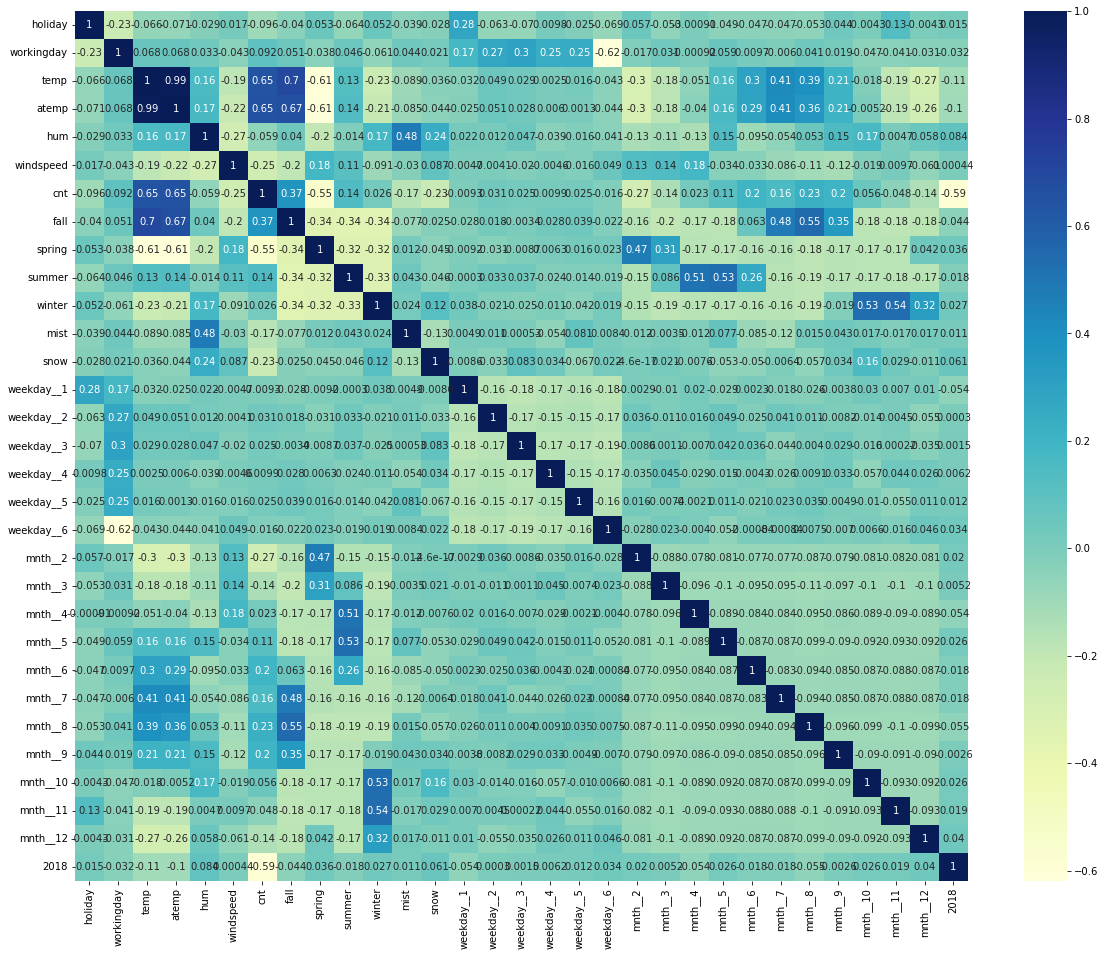

In [182]:
#First plotting a heatmap to understand correlation at a high level

plt.figure(figsize = (20,16))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

From the above map, we can see that the most significant predictors are temp and atemp, both with 0.65

Also, we find that temp and atemp are correlated with corr ratio of 0.99, which is much more than the acceptable ratio/

In [350]:
#Diving into X and y sets for model building

y_train = df_train.pop('cnt')
X_train = df_train

## Recursive feature elimination

We will now use sklearn's feature elimination library to do automatic feature selection

We know that the number of features we have in the dataset is 30, so to start off with, we can include 20 features and see the result

In [351]:
# fitting the linear regression model on the training dataset

lm = LinearRegression()
lm.fit(X_train, y_train)

#Running rfe with all features first

rfe = RFE(lm, 28)
rfe = rfe.fit(X_train, y_train)


C:\Users\Aditya\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=28 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [352]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('mist', True, 1),
 ('snow', True, 1),
 ('weekday__1', True, 1),
 ('weekday__2', True, 1),
 ('weekday__3', True, 1),
 ('weekday__4', False, 2),
 ('weekday__5', True, 1),
 ('weekday__6', True, 1),
 ('mnth__2', True, 1),
 ('mnth__3', True, 1),
 ('mnth__4', True, 1),
 ('mnth__5', True, 1),
 ('mnth__6', True, 1),
 ('mnth__7', True, 1),
 ('mnth__8', True, 1),
 ('mnth__9', True, 1),
 ('mnth__10', True, 1),
 ('mnth__11', True, 1),
 ('mnth__12', True, 1),
 (2018, True, 1)]

In [353]:
# Selecting only those features that RFE recommended

col = X_train.columns[rfe.support_]
col

Index([   'holiday', 'workingday',       'temp',      'atemp',        'hum',
        'windspeed',     'spring',     'summer',     'winter',       'mist',
             'snow', 'weekday__1', 'weekday__2', 'weekday__3', 'weekday__5',
       'weekday__6',    'mnth__2',    'mnth__3',    'mnth__4',    'mnth__5',
          'mnth__6',    'mnth__7',    'mnth__8',    'mnth__9',   'mnth__10',
         'mnth__11',   'mnth__12',         2018],
      dtype='object')

In [354]:
#Creating the X_train dataset with RFE selected variables

X_train_rfe = X_train[col]

## Building the model

We will now build the linear regression model using statsmodel api for detailed statistics

In [355]:
#Since statsmodel's best fit line passes through the origin by default, we have to add the constant column for error

X_train_rfe = sm.add_constant(X_train[col])

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [356]:
#Fitting the model

lm = sm.OLS(y_train, X_train_rfe).fit()

In [357]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          2.81e-180
Time:                        12:03:38   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4537      0.043     10.647      0.0

As observed above, the stats of the model are as below:

*r-squared score*        - 0.853
*P-value of f-statistic* - 1.53e-187

Which means that the model is significant enough to be considered valid. 

However, we can see that the p-values of atemp is significantly high - we also saw from the heatmap that atemp was highly correlated to temp.

Therefore, we can safely remove atemp

In [358]:
#Rebuilding the model without atemp

X_train_new = X_train_rfe.drop(['atemp'], axis = 1)

X_train_new = sm.add_constant(X_train_new)

#Fitting the new model
lm = sm.OLS(y_train, X_train_new).fit()

#Summary of the new model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          3.00e-181
Time:                        12:04:05   Log-Likelihood:                 527.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     482   BIC:                            -879.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4536      0.043     10.653      0.0

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Here, we see that the r squared score hasnt changed, so we will try and plot VIF for the variables

In [359]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,117.88
6,spring,10.75
22,mnth__8,9.80
8,winter,9.44
21,mnth__7,8.82
7,summer,8.27
3,temp,7.08
20,mnth__6,6.90
23,mnth__9,6.70
19,mnth__5,6.57


As we can see, VIF of the spring is high, so we can drop spring column and rebuild the model

In [360]:
#Rebuilding the model without spring

X_train_new = X_train_new.drop(['spring'], axis = 1)


#Fitting the new model
lm = sm.OLS(y_train, X_train_new).fit()

#Summary of the new model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          8.68e-182
Time:                        12:04:23   Log-Likelihood:                 525.85
No. Observations:                 510   AIC:                            -997.7
Df Residuals:                     483   BIC:                            -883.4
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4086      0.030     13.540      0.0

Let us look at the VIF once again

In [361]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,59.06
3,temp,6.97
7,winter,6.04
18,mnth__5,6.03
21,mnth__8,5.86
19,mnth__6,5.77
20,mnth__7,5.71
23,mnth__10,5.33
24,mnth__11,4.77
6,summer,4.73


Temp also has a high enough vif score that we can choose to drop it

In [362]:
#Rebuilding the model without temp

X_train_new = X_train_new.drop(['temp'], axis = 1)

#Fitting the new model
lm = sm.OLS(y_train, X_train_new).fit()

#Summary of the new model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     89.32
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          1.29e-163
Time:                        12:04:42   Log-Likelihood:                 478.83
No. Observations:                 510   AIC:                            -905.7
Df Residuals:                     484   BIC:                            -795.6
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4506      0.033     13.769      0.0

In [363]:
#Computing the new vif of the model

# Computing new VIF

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,57.89
6,winter,6.04
5,summer,4.68
23,mnth__11,4.43
22,mnth__10,4.37
17,mnth__5,3.78
16,mnth__4,3.62
2,workingday,3.25
24,mnth__12,3.03
18,mnth__6,2.50


However, the winter variable still has a high p value, so removing spring and rebuilding as well

In [364]:
#Rebuilding the model without winter

X_train_new = X_train_new.drop(['winter'], axis = 1)

#Fitting the new model
lm = sm.OLS(y_train, X_train_new).fit()

#Summary of the new model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     87.10
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          8.34e-159
Time:                        12:05:26   Log-Likelihood:                 464.64
No. Observations:                 510   AIC:                            -879.3
Df Residuals:                     485   BIC:                            -773.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4545      0.034     13.526      0.0

In [365]:
#Computing the new vif of the model

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,57.86
5,summer,4.68
16,mnth__5,3.78
15,mnth__4,3.62
2,workingday,3.25
17,mnth__6,2.50
14,mnth__3,2.23
19,mnth__8,1.95
3,hum,1.90
8,weekday__1,1.90


## Residual Analysis

To check whether error terms are normally distributed

In [366]:
y_train_pred = lm.predict(X_train_new)

C:\Users\Aditya\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

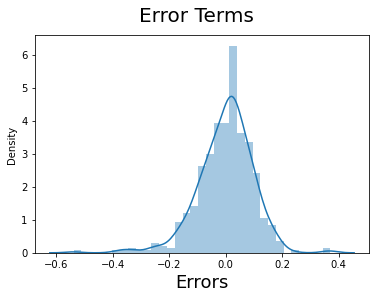

In [367]:
#Plot histogram of error terms

fig = plt.figure()
sns.distplot(y_train - y_train_pred)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

As we can see, the residuals are fairly normal, with mean centered around 0, so we can proceed with predictions

## Making predictions using the final model

Making predictions on the test set using the above linear model

In [368]:
#Applying scaling on the test set

num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

df_test.describe()

C:\Users\Aditya\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.090909,0.086364,0.095455,0.104545,0.059091,0.086364,0.086364,0.072727,0.086364,0.518182
std,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.288135,0.281541,0.294512,0.306665,0.236333,0.281541,0.281541,0.260281,0.281541,0.500809
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [369]:
#Dividing into X and y test

y_test = df_test.pop('cnt')
X_test = df_test

In [373]:
# Dropping all the insignificant variables found during model building

X_test_new = X_test[col]

X_test_new.head()

X_test_new = sm.add_constant(X_test_new)

C:\Users\Aditya\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [374]:
X_test_new.drop('atemp', axis = 1, inplace = True)
X_test_new.drop('spring', axis = 1, inplace = True)
X_test_new.drop('temp', axis = 1, inplace = True)
X_test_new.drop('winter', axis = 1, inplace = True)


X_test_new.head()


,const,holiday,workingday,hum,windspeed,summer,mist,snow,weekday__1,weekday__2,...,mnth__4,mnth__5,mnth__6,mnth__7,mnth__8,mnth__9,mnth__10,mnth__11,mnth__12,2018
184,1.0,1,0,0.657364,0.084219,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
535,1.0,0,1,0.610133,0.153728,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
299,1.0,0,1,0.837699,0.334206,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
221,1.0,0,1,0.437098,0.339570,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
152,1.0,0,1,0.314298,0.537414,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [375]:
# Making predictions
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

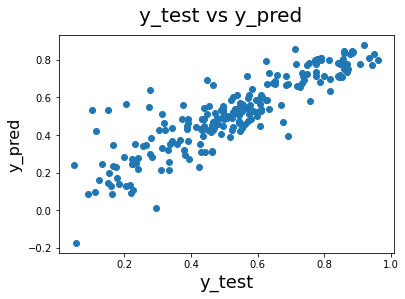

In [376]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [377]:
#Calulating r2score as mentioned in the problem statement

r2_score(y_test, y_pred)

0.7679076552891653

# Final Conclusions

The final coefficients given by the model is as follows:


In [378]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     87.10
Date:                Sat, 18 Jun 2022   Prob (F-statistic):          8.34e-159
Time:                        12:09:09   Log-Likelihood:                 464.64
No. Observations:                 510   AIC:                            -879.3
Df Residuals:                     485   BIC:                            -773.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4545      0.034     13.526      0.000       0.388       0.521
holiday       -0.0293      0.034     -0.872      0.383      -0.095       0.037
workingday     0.0536      0.017      3.149      0.002       0.020       0.087
hum           -0.0473      0.042     -1.132      0.258      -0.129       0.035
windspeed     -0.1979      0.029     -6.879      0.000      -0.254      -0.141
summer         0.0480      0.022      2.166      0.031       0.004       0.092
mist          -0.0788      0.012     -6.841      0.000      -0.101      -0.056
snow          -0.2875      0.029     -9.779      0.000      -0.345      -0.230
weekday__1    -0.0149      0.017     -0.874      0.382      -0.048       0.019
weekday__2    -0.0076      0.017     -0.437      0.662      -0.042       0.027
weekday__3     0.0024      0.017      0.146      0.884      -0.030       0.035
weekday__5     0.0073      0.017      0.417      0.677      -0.027       0.042
weekday__6     0.0568      0.016      3.474      0.001       0.025       0.089
mnth__2        0.0674      0.023      2.944      0.003       0.022       0.112
mnth__3        0.1697      0.022      7.646      0.000       0.126       0.213
mnth__4        0.2314      0.031      7.397      0.000       0.170       0.293
mnth__5        0.3128      0.031     10.122      0.000       0.252       0.373
mnth__6        0.3551      0.026     13.504      0.000       0.303       0.407
mnth__7        0.3564      0.022     16.048      0.000       0.313       0.400
mnth__8        0.3821      0.021     18.267      0.000       0.341       0.423
mnth__9        0.4203      0.022     19.096      0.000       0.377       0.464
mnth__10       0.3528      0.022     16.119      0.000       0.310       0.396
mnth__11       0.2516      0.021     11.775      0.000       0.210       0.294
mnth__12       0.1728      0.021      8.040      0.000       0.131       0.215
2018          -0.2478      0.009    -27.718      0.000      -0.265      -0.230
==============================================================================
Omnibus:                       80.621   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.098
Skew:                          -0.734   Prob(JB):                     8.11e-55
Kurtosis:                       6.093   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above output, we can conclude the following:

- From the months categorical variable shown above, month_9 (September) has the highest positive coefficient - 0.4203,
  hence we can conclude that the bike sales peak in the month of September
  
- We can also see that windspeed has a significant negatvie coefficient (-0.1979), which means that an increase in    
  windspeed lead to decreased bike sales as people find it difficult to ride bikes

- The weather situation also plays a significant role, wherein a light snow + heavy rain causes a dcrese in bike sales

- We can also see that the sales were significantly less in 208 than in 2019, which may mean that in 2019 people came to 
  know about boombikes through word of mouth and increased sales